# 1. Setting up

In [113]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [114]:
!nvidia-smi

Sun Feb 16 16:33:41 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.120                Driver Version: 550.120        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4050 ...    Off |   00000000:01:00.0 Off |                  N/A |
| N/A   38C    P8              1W /   55W |     474MiB /   6141MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# 2. Data preparation

## a) Checking images

In [115]:
import os

data_path = "data/"
test_path = data_path + "/test"
train_path = data_path + "/train"

In [116]:
def walk_through_dir(dir):
    for dirpaths, dirnames, filenames in os.walk(dir):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpaths}")
walk_through_dir(data_path)

There are 2 directories and 0 images in data/
There are 4 directories and 0 images in data/train
There are 0 directories and 274 images in data/train/Asian
There are 0 directories and 115 images in data/train/Indian
There are 0 directories and 268 images in data/train/Negroids
There are 0 directories and 117 images in data/train/Caucasian
There are 4 directories and 0 images in data/test
There are 0 directories and 69 images in data/test/Asian
There are 0 directories and 29 images in data/test/Indian
There are 0 directories and 68 images in data/test/Negroids
There are 0 directories and 30 images in data/test/Caucasian


### Check the sizes of the images

In [117]:
from PIL import Image
import os
from collections import Counter

In [118]:
size_counts = Counter()
for subfolder in os.listdir(train_path):
    subfolder_path = train_path + "/" + subfolder
    for filename in os.listdir(subfolder_path):
            file_path = subfolder_path + "/" + filename
            with Image.open(file_path) as img:
                size = img.size  # (width, height)
                size_counts[size] += 1

for size, count in size_counts.items():
    print(f'Size {size}: {count} images')

Size (224, 224): 774 images


## b) Creating datasets

In [119]:
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_path)
test_data = datasets.ImageFolder(root=test_path)
class_names = train_data.classes

## c) Data preprocessing

### i) Datasets before

In [120]:
def imgs_per_class(dataset):
    labels = [label for _, label in dataset.samples]
    class_counts = Counter(labels) 
    for class_ind, num in class_counts.items():
        print(f"{class_names[class_ind]}: {num}")
imgs_per_class(train_data)

Asian: 274
Caucasian: 117
Indian: 115
Negroids: 268


### ii) Upsampling

In [121]:
import numpy as np
from torch.utils.data import Subset

# Find the largest class size
labels = [labels for _, labels in train_data.samples]
class_counts = Counter(labels) 
max_class_count = max(class_counts.values())

# Upsample minority class
new_train_data = []
for class_ind in class_counts.keys():
    # Find indices of current class
    class_indices = [i for i, label in enumerate(labels) if label == class_ind]
    print(class_indices)
    # Repeat indices 
    upsampled_indices = np.random.choice(class_indices, max_class_count, replace=True)
    new_train_data.extend(train_data.samples[i] for i in upsampled_indices)
train_data.samples = new_train_data

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

### iii) Datasets after

In [122]:
imgs_per_class(train_data)

Asian: 274
Caucasian: 274
Indian: 274
Negroids: 274


## d) Creating transforms and apply data augmentation

In [123]:
from torchvision import transforms

img_transform = transforms.Compose([
    # transforms.Lambda(lambda img: img.convert('RGBA')), # as some img are in Palette mode
    # then turn them back into only 3 color channels
    # transforms.Lambda(lambda img: Image.new('RGB', img.size, (255, 255, 255)).paste(img, mask=img.split()[3])),
    transforms.Resize(size=(224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])
train_data.transform = img_transform
test_data.transform = img_transform

## e) Turn datasets into dataloaders

In [124]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32
num_workers = os.cpu_count()

train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, num_workers=num_workers, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, num_workers=num_workers, shuffle=False)


## f) Visualize the images after changes

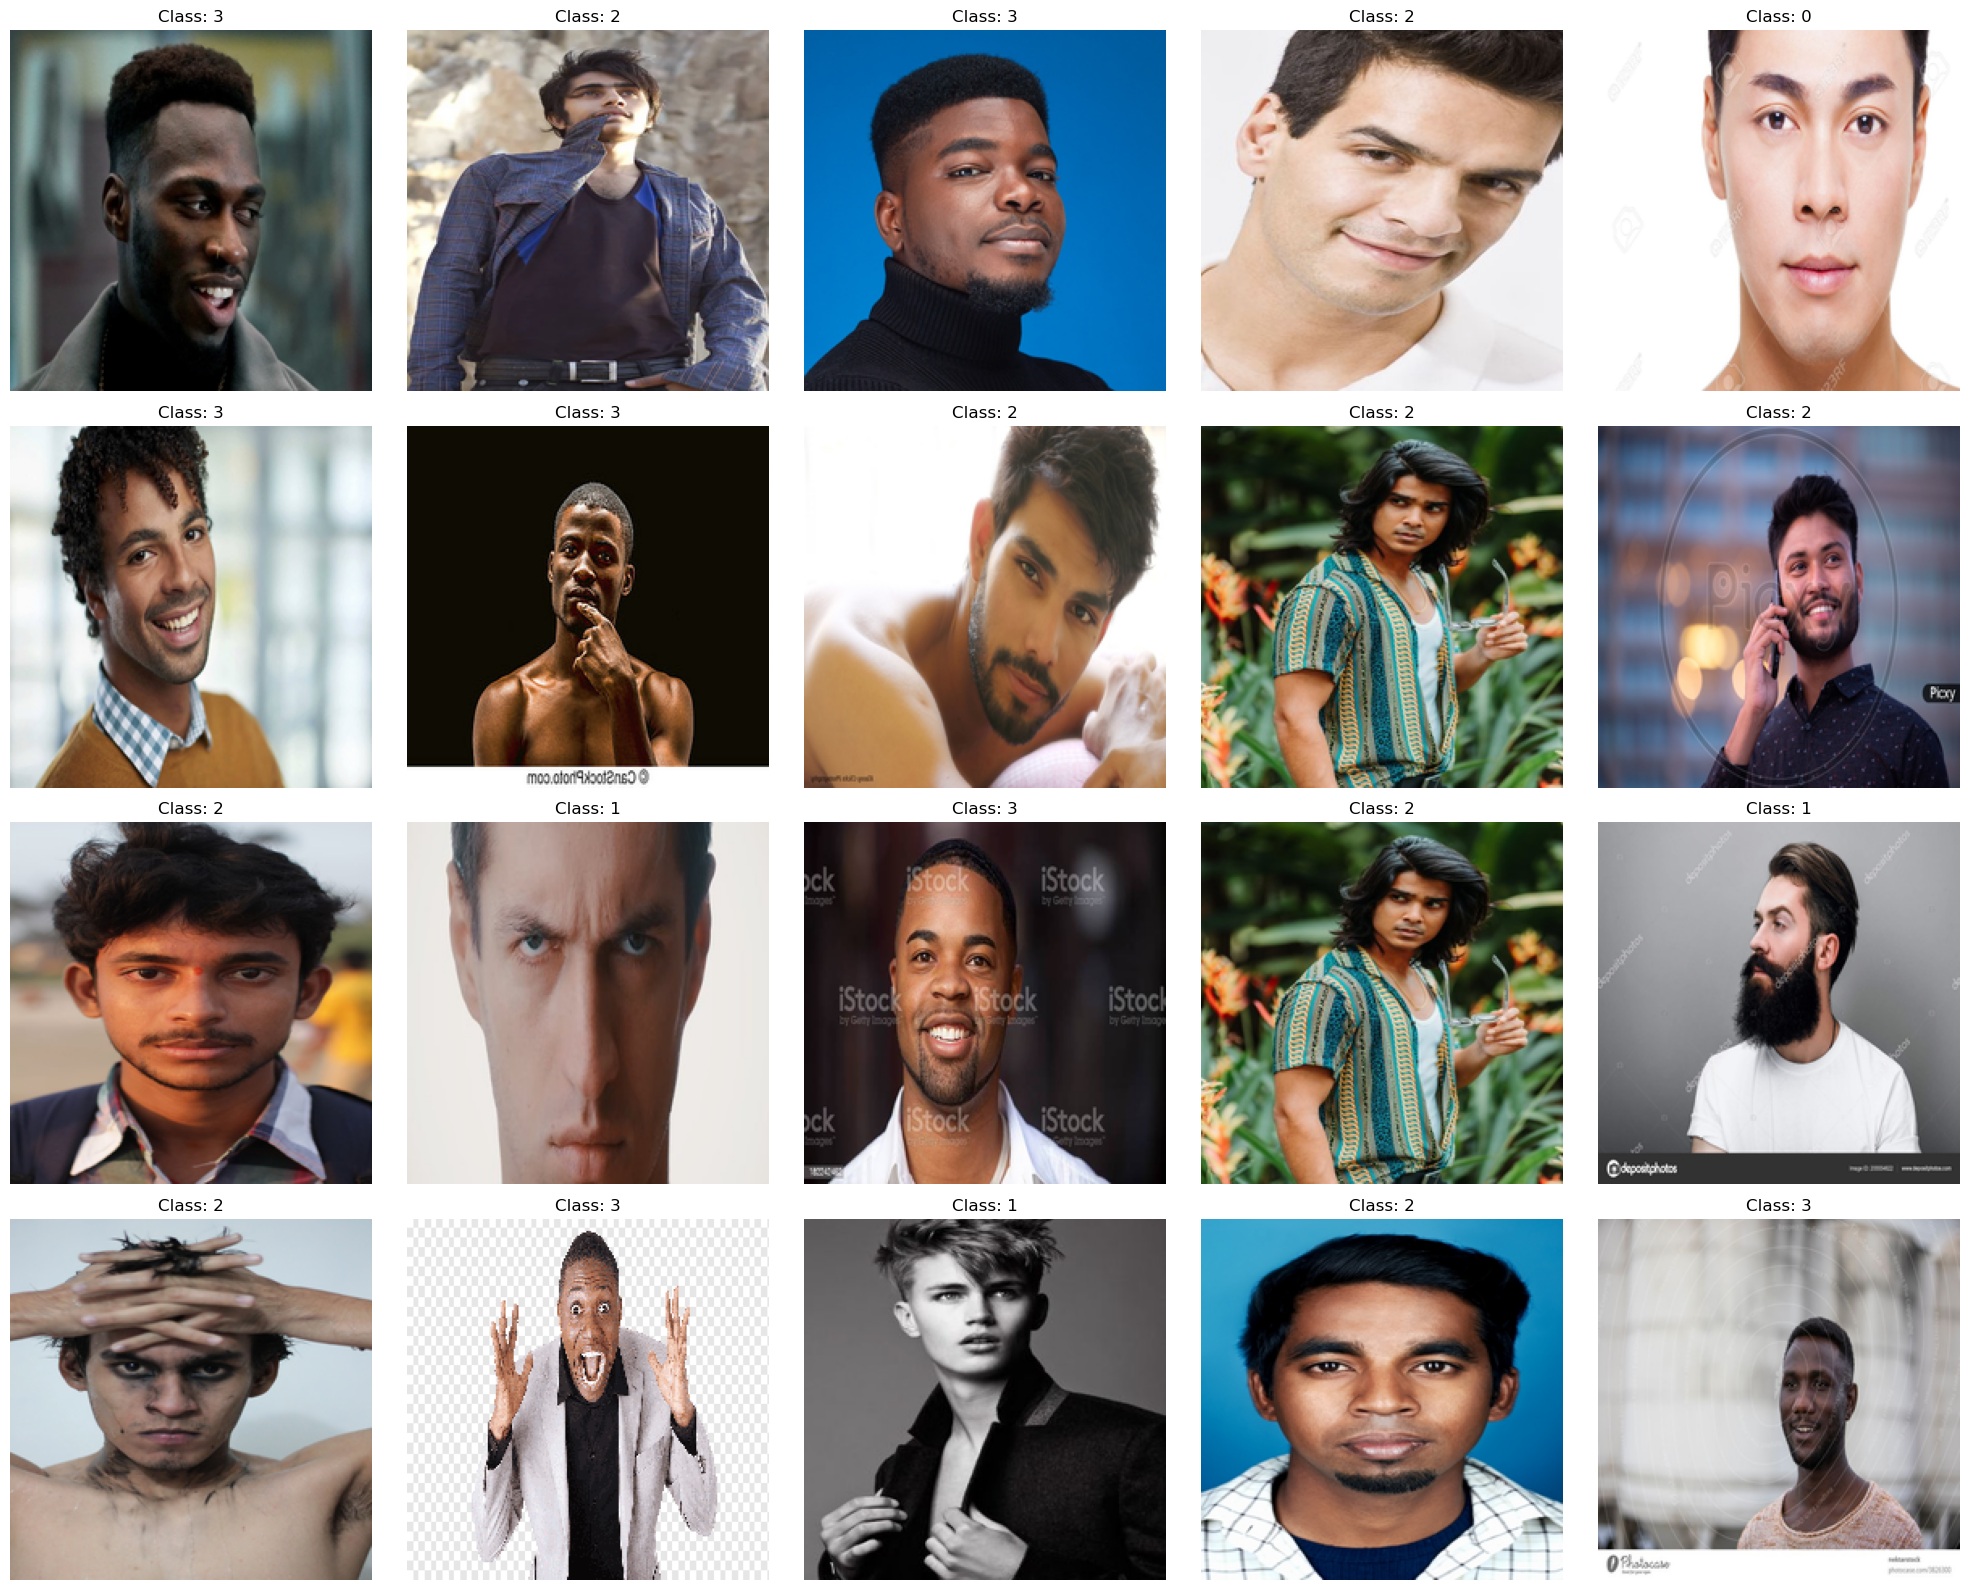

In [139]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Get one batch of images and labels
images, labels = next(iter(train_dataloader))

# Randomly select 20 indices
random_indices = np.random.choice(images.size(0), 20, replace=False)

# Convert from Tensor (C, H, W) to NumPy (H, W, C) for display
images = images.permute(0, 2, 3, 1).numpy()

# Plot the 20 random images in a 4x5 grid
fig, axs = plt.subplots(4, 5, figsize=(20, 16))
axs = axs.flatten()
for idx, ax in zip(random_indices, axs):
    ax.imshow(images[idx])
    ax.set_title(f"Class: {labels[idx].item()}")
    ax.axis('off')
plt.tight_layout()
plt.show()

# 3. Create the TinyVGG architecture model

In [125]:
from torch import nn
class TinyVGG(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=56*56*10, out_features=output_shape)
        )
    def forward(self, x):
        return self.classifier(self.conv_block2(self.conv_block1(x)))

In [126]:
model_0 = TinyVGG(input_shape=3, hidden_units=10, output_shape=len(train_data.classes))
model_0

TinyVGG(
  (conv_block1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=31360, out_features=4, bias=True)
  )
)

# 4. Training and testing

## Train step and test step function

In [127]:
import torch.utils.data.dataloader


def train_step(model: nn.Module, dataloader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, 
          optimizer: torch.optim.Optimizer):
    model.train()
    train_loss, train_acc= 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        logits = model(X)
        loss = loss_fn(logits, y)
        train_loss += loss.cpu().detach().numpy() # for plotting loss in matplotlib later(requires numpy arr)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        labels = torch.argmax(torch.softmax(logits, dim=1), dim=1)
        train_acc += (labels == y).sum().item()/len(y)
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    return train_loss, train_acc

In [128]:
def test_step(model: nn.Module, dataloader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module ):
    model.eval()
    test_loss, test_acc = 0, 0 
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            logits = model(X)
            loss = loss_fn(logits, y)
            test_loss += loss.cpu().detach().numpy() # for plotting loss in matplotlib later(requires numpy arr)

            labels = torch.argmax(torch.softmax(logits, dim=1), dim=1)
            test_acc += (labels == y).sum().item() / len(y)
        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
    return test_loss, test_acc


## Train function

In [129]:
from tqdm.auto import tqdm
def train(model: nn.Module, train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = torch.nn.CrossEntropyLoss(), epochs: int = 1, device = device):
  model.to(device)
  result = {
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": []
  }
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model, dataloader=train_dataloader, optimizer=optimizer, loss_fn=loss_fn)
    test_loss, test_acc = test_step(model=model, dataloader=test_dataloader, loss_fn=loss_fn)

    print(f"Epoch: {epoch+1} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")
    result["train_loss"].append(train_loss)
    result["train_acc"].append(train_acc)
    result["test_loss"].append(test_loss)
    result["test_acc"].append(test_acc)
  return result

## Train the model

In [130]:
torch.manual_seed(27)
torch.cuda.manual_seed(27)

NUM_EPOCHS = 30

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.01)

from timeit import default_timer as timer
start_time = timer()
model_0_result = train(model=model_0, train_dataloader=train_dataloader, test_dataloader=test_dataloader,
                       optimizer=optimizer, loss_fn=loss_fn, epochs=NUM_EPOCHS)
end_time = timer()
print(f"Total training time on {device}: {end_time - start_time}")


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | Train loss: 2.5892 | Train acc: 0.2536 | Test loss: 1.3929 | Test acc: 0.1339
Epoch: 2 | Train loss: 1.3871 | Train acc: 0.2473 | Test loss: 1.3940 | Test acc: 0.1339
Epoch: 3 | Train loss: 1.3871 | Train acc: 0.1982 | Test loss: 1.3861 | Test acc: 0.1339
Epoch: 4 | Train loss: 1.3872 | Train acc: 0.2375 | Test loss: 1.3872 | Test acc: 0.1339
Epoch: 5 | Train loss: 1.3874 | Train acc: 0.2313 | Test loss: 1.3864 | Test acc: 0.1295
Epoch: 6 | Train loss: 1.3870 | Train acc: 0.2384 | Test loss: 1.3867 | Test acc: 0.1295
Epoch: 7 | Train loss: 1.3870 | Train acc: 0.2295 | Test loss: 1.3884 | Test acc: 0.3080
Epoch: 8 | Train loss: 1.3868 | Train acc: 0.2339 | Test loss: 1.3853 | Test acc: 0.4286
Epoch: 9 | Train loss: 1.3870 | Train acc: 0.2473 | Test loss: 1.3830 | Test acc: 0.4286
Epoch: 10 | Train loss: 1.3880 | Train acc: 0.2446 | Test loss: 1.3852 | Test acc: 0.3080
Epoch: 11 | Train loss: 1.3872 | Train acc: 0.2357 | Test loss: 1.3869 | Test acc: 0.3080
Epoch: 12 | Train l

# 5. Evaluating the model

In [131]:
import matplotlib.pyplot as plt

In [132]:
def plot_loss_curve(result):
    """Plot the training and test loss/acc curve from a dictionary"""
    train_loss = result["train_loss"]
    test_loss = result["test_loss"]
    train_acc = result["train_acc"]
    test_acc = result["test_acc"]
    epochs = range(len(train_loss))

    plt.figure(figsize=(10,6))
    # Plot the loss 
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label="Train loss")
    plt.plot(epochs, test_loss, label="Test loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot the accuracy
    plt.subplot(1, 2 ,2)
    plt.plot(epochs, train_acc, label="Train acc")
    plt.plot(epochs, test_acc, label="Test acc")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

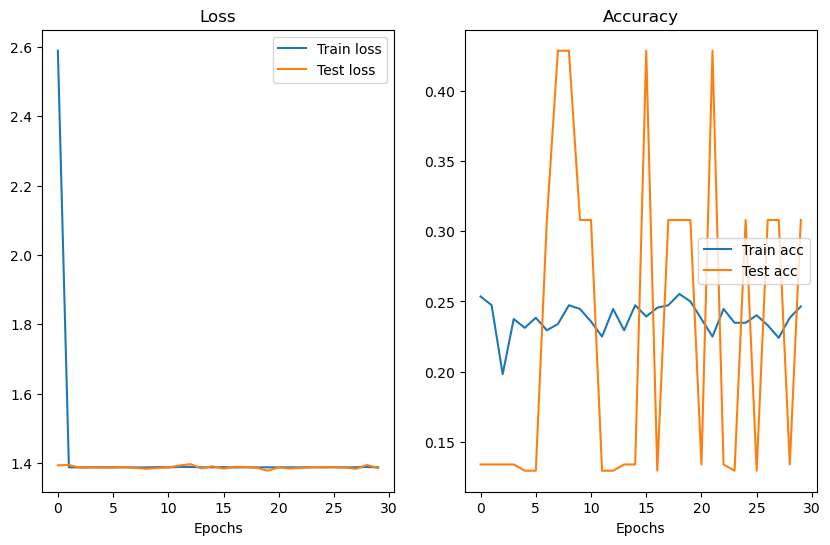

In [133]:
plot_loss_curve(model_0_result)